# Deep Learning - Lab Exercise 2

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST datasetÂ (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy.
However, it can quickly become really impracical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass once, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)


In [231]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as patches
import math
from scipy.stats import pearsonr

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# Data

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [3]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 9


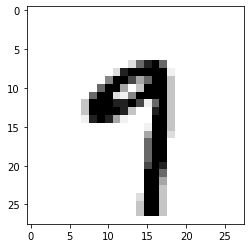

In [4]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kind of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and incorrect in the general case (i.e. won't work with computation graph with loops).
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

In [5]:
class Tensor:
    def __init__(self, data, require_grad=False):
        # test type of data: should be np array
        if isinstance(data, float):
            data = np.array([data,])
        if type(data) != np.ndarray:
            raise RuntimeError("Input should be a numpy array")

        # store data for this tensor
        self.data = data
        self.require_grad = require_grad
        
        # this values should be set to enable autograd!
        self.gradient = None
        self.d = None
        self.backptr = None
        
    def zero_grad(self):
        """
        Set the gradient of thie tensor to 0
        """
        if self.require_grad:
            self.gradient = np.zeros_like(self.data)
            
    def accumulate_gradient(self, gradient):
        """
        Accumulte gradient for this tensor
        """
        if gradient.shape != self.data.shape:
            raise RuntimeError("Invalid gradient dimension")

        if self.gradient is None:
            self.gradient = np.copy(gradient)
        else:
            self.gradient += gradient
            
    def backward(self, g=None):
        """
        The backward pass!
        If g != None, then g is the gradient for the current node.
        i.e. g will be != None only for the loss output.
        
        You should call the function stored in self.d with correct arguments,
        and then recursively call the backward methods of tensors in the backptr list if:
        1. they require a gradient
        2. they are of type Tensor: check with isinstance(o, Tensor)
        """
        if not self.require_grad:  # stop right now if this node does not require a gradient
            return
        
        if g is not None:
            if isinstance(g, float):
                g = np.array([g])
            if type(g) != np.ndarray:
                raise RuntimeError("Gradient should be a numpy array")
            if g.shape != self.data.shape:
                raise RuntimeError("Gradient of different size than the value!")
                
            self.gradient = g

        # run the backward operation of the tensor
        self.d(self.backptr, self.gradient)
        
        # run the backward operation of each tensor in the list if (it's a tensor, not a Parameter, and requires to compute the gradient)
        for ptr in self.backptr:
            if hasattr(ptr,'require_grad') and ptr.require_grad and isinstance(ptr, Tensor) and not isinstance(ptr, Parameter):
                ptr.backward()

    
class Parameter(Tensor):
    """
    This class will be used to store parameters of the network only!
    """
    def __init__(self, data, name="unamed"):
        super().__init__(data, require_grad=True)
        self.name = name
        
    def backward(self):
        raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [6]:
def any_require_grad(l):
    """
    Input:
    - l: an iterable (e.g. a list)
    Ouput:
    - True if any tensor in the input requires a gradient
    """
    return any(t.require_grad for t in l)

In [7]:
# Here is an exemple with the ReLU
def relu(x):
    v = np.maximum(0, x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_relu
    output.backptr = [x]
    
    return output

def backward_relu(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (x.data > 0))

In [279]:
def tanh(x):
    '''
    The same logic as for relu, but with a different activation function, defined in v
    '''
    v = (np.exp(2*x.data)-1) / ( np.exp(2*x.data)+1) 
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_tanh
    output.backptr = [x]
    
    return output

def backward_tanh(backptr, g):
    '''
    The same logic as for relu, but with a different activation function, defined in v
    '''
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:   
        # grad_tanh = 1 - tanh**2
        grad_tanh = 1 - ((np.exp(2*x.data)-1) / ( np.exp(2*x.data)+1) )**2
        x.accumulate_gradient(g * grad_tanh)

Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one major difference: you have to compute the gradient with respect to x too!

In [9]:
def affine_transform(W, b, x):
    v = W.data @ x.data + b.data
    
    output = Tensor(v, require_grad=any_require_grad([W, b, x]))
    output.d = backward_affine_transform
    output.backptr = [W, b, x]
    
    return output

def backward_affine_transform(backptr, g):
    W, b, x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if W.require_grad:
        # we use expand_dims to be able to take the transpose of x
        W.accumulate_gradient(np.expand_dims(g,axis=1) @  np.expand_dims(x.data,axis=1).T)
    if b.require_grad:
        # the grad here is g * 1 = g
        b.accumulate_gradient(g)
    if isinstance(x, Tensor) and x.require_grad:
        # print(W.data.shape, b.data.shape, x.data.shape, g.shape, (g @ W.data).shape)
        # (10, 100) (10,) (100,) (10,) (100,)
        x.accumulate_gradient(g @ W.data)

In [10]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
    x = np.array(x)    # ensure that x is a numpy array and not a list
    exp_norm = x.max()        # b will be used to normalize
    exp_sum = np.exp(x - exp_norm).sum()   # the sum of the exponential
    return np.exp(x - exp_norm)/exp_sum

def nll(x, gold):
    # gold should be a Parameter (has an attr require_grad)
    v = -np.log(_softmax(x.data)[gold])
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_nll
    output.backptr = [x, gold]
    
    return output

def backward_nll(backptr, g):
    x, gold, = backptr
    if x.require_grad:
        # compute the grad of the first half
        first_term = - (np.arange(x.data.shape[0]) == gold).astype(int)
        # compute the grad of the second half
        second_term = _softmax(x.data)
        # compute the final grad
        x.accumulate_gradient(g * (first_term + second_term))

# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [11]:
class Module:
    def __init__(self):
        raise NotImplemented("")
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)
            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

# Initialization and optimization

In [12]:
def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    # initialize parameters following xavier initialization
    m, n = W.shape
    u = np.sqrt(6)/np.sqrt(m+n)
    W[:] = np.random.uniform(-u, u, W.shape)
    
def kaiming_init(W):
    # initialize parameters following kaiming initialization
    m, n = W.shape
    W[:] = np.random.normal(0, 2/n , W.shape)

In [87]:
def triggerLearningRateDecay(train_loss):
    """ check if we need to reduce the learning rate

    Args:
        train_loss (list): list of training losses

    Returns:
        Bool: Whether or not to reduce the learning rate
    """
    if len(train_loss) > 2:
        lastChangeInLoss = train_loss[-2]-train_loss[-1]
        if lastChangeInLoss < 0:
            return True;
    return False

In [158]:
# simple gradient descent optimizer
class SGD:
    def __init__(self, params, lr=0.1, lrDecay = True):
        self.params = params
        self.lr = lr
        self.lrDecay = lrDecay
        
    def step(self):
        for p in self.params:
            p.data[:] = p.data - self.lr * p.gradient
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()
            
            
class MomtenumSGD(SGD):
    def __init__(self, params, lr=0.1, beta = 0.95, lrDecay = True):
        super().__init__(params, lr = lr, lrDecay = lrDecay)
        self.prevVelocityParams = []
        self.beta = beta
        for p in params:
            self.prevVelocityParams.append(np.zeros_like(p.data))
        
    def step(self):
        for pIndex in range(len(self.prevVelocityParams)):
            p = self.params[pIndex]
            veloP = self.prevVelocityParams[pIndex]
            self.prevVelocityParams[pIndex] = self.beta*veloP + (1-self.beta)*p.gradient
            p.data[:] = p.data - self.lr * self.prevVelocityParams[pIndex]
        

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

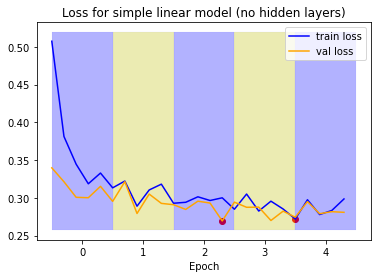

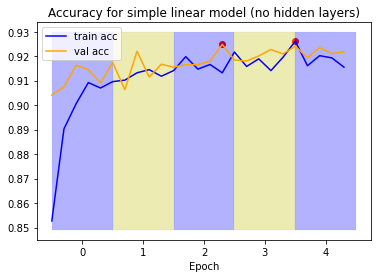

In [74]:
plot_loss_and_accuracy(linear_history, linear_network)

In [104]:
def plot_loss_and_accuracy(history, module):
    for evalType, minOrMax in (("loss", np.argmin),("acc", np.argmax)):
        plt.figure()
        minY = 1
        maxY = 0
        
        for dataType, color in (("train","blue"),("val","orange")):
            
            linHistoryKey = evalType + "_" + dataType
            plt.plot(history[linHistoryKey],label=dataType + " " + evalType, c=color)
            
            bestIndex = minOrMax(history[linHistoryKey])
            plt.scatter(bestIndex, history[linHistoryKey][bestIndex],c="red")
            
            numMeasurements = len(history[linHistoryKey])
            minY = min(minY, min(history[linHistoryKey]))
            maxY = max(maxY, max(history[linHistoryKey]))
        

        patchHeight = maxY-minY
        minY -= patchHeight*0.05
        maxY += patchHeight*0.05
        patchHeight = maxY-minY
        measPerEpoch = numMeasurements/history["n_epochs"]
        for epoch in range(history["n_epochs"]):
            #xy, width, height
            rect = patches.Rectangle((epoch*measPerEpoch, minY), measPerEpoch, patchHeight, linewidth=0.1, edgecolor='b', facecolor=("b" if epoch % 2 == 0 else "y"),alpha=0.3)
            plt.gca().add_patch(rect)
        
        plt.xticks(np.arange(history["n_epochs"])*measPerEpoch+measPerEpoch/2,np.arange(history["n_epochs"]))
        plt.xlabel("Epoch")
        plt.legend()
        if type(module) == DeepNetwork:
            title = ("Accuracy" if evalType == "acc" else "Loss") + " for " + module.name + " network with " + str(module.n_layers) + " hidden layers of dimension " + str(module.hidden_dim)
        else:
            title = ("Accuracy" if evalType == "acc" else "Loss") + " for " + module.name + " simple linear model (no hidden layers)"
        plt.title(title)  

In [97]:
class LinearNetwork(Module):
    def __init__(self, dim_input, dim_output, name = ""):
        # build the parameters
        self.W = Parameter(np.ndarray((dim_output, dim_input)), name="W")
        self.b = Parameter(np.ndarray((dim_output,)), name="b")
        self.name = name
        self.init_parameters()
    def init_parameters(self):
        # init parameters of the network (i.e W and b) following xavier initialization
        glorot_init(self.W.data)
        zero_init(self.b.data)
    def forward(self, x):
        # the forward pass in the network
        return affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [187]:
from sklearn.utils import shuffle
from tqdm.notebook import tqdm

def evaluate(network, data):
    """ computes the loss and accuracy of a given network on a given data

    Args:
        network (object): a linear or a deep network to evaluate
        data (object): the dataset on which perform the evaluation

    Returns:
        (int, int): loss, accuracy
    """
    loss_h = []
    acc_h = []
    for x, gold in zip(data[0], data[1]):

        # transform x from a numpy vector to an object Parameter
        x = Parameter(x, name='x')

        # forward x to get the prediction
        logits = network.forward(x)
        y_pred = np.argmax(_softmax(logits.data))
        loss = nll(logits, gold)

        loss_h.append(loss.data)
        acc_h.append(int(gold==y_pred))

    return np.array(loss_h).mean(), np.array(acc_h).mean()


def training_loop(network, optimizer, train_data, dev_data, n_epochs=10):

    n_eval = 5 # number of evaluations on the dev set per epoch

    # variable in which the history of the training will be stored
    history = {
        'loss_train': [],
        'loss_val': [],
        'acc_train': [],
        'acc_val': [],
        'acc_test':[],
        'loss_test':[],
        "n_epochs":n_epochs
    }

    # to remember the weights that gave the best score
    W_best, b_best, loss_best, acc_best = network.W, network.b, float('inf'), float('-inf')

    for epoch in tqdm(range(n_epochs)):
        # shuffle the data at each iteration
        X, y = shuffle(train_data[0], train_data[1])
        loss_h = []
        acc_h = []

        # to know when to evaluate when to do the evaluation on the dev set
        v = int(X.shape[0] / n_eval)

        for i, (x, gold) in enumerate(zip(X, y)):

            # transform x into a Parameter and forward it through the network
            x = Parameter(x, name='x')
            logits = network.forward(x)
            loss = nll(logits, gold)

            # put the gradient back to 0 before each update (step)
            optimizer.zero_grad()
            loss.backward(1.)   # incoming gradient for the loss function is 1
            optimizer.step()


            # save the history of the training
            loss_h.append(loss.data)
            y_pred = np.argmax(_softmax(logits.data))
            acc_h.append(int(gold==y_pred))

            # evaluation on the dev set
            if not (i+1)%v:
                
                # save the history of the evaluation
                history['loss_train'].append(np.array(loss_h).mean())
                history['acc_train'].append(np.array(acc_h).mean())
                loss_h = []
                acc_h = []
                
                # do the evaluation
                loss_val, acc_val = evaluate(network, dev_data)
                print("current loss",loss_val,"and accuracy",acc_val)
                history['acc_val'].append(acc_val)
                history['loss_val'].append(loss_val)
                
                loss_test, acc_test = evaluate(network, test_data)
                print("current test loss",loss_test,"and accuracy",acc_test)
                history['acc_test'].append(acc_test)
                history['loss_test'].append(loss_test)

                # check if these parameters gave the best score yet
                if acc_val > acc_best:
                    W_best, b_best, loss_best, acc_best = network.W, network.b, loss_val, acc_val
                    
                # lower the learning if needed
                if optimizer.lrDecay and triggerLearningRateDecay(history["loss_val"]):
                    print("triggering lr decay")
                    optimizer.lr *= 0.5
                    
        

    return history
 

Evaluation on the test set: loss=0.311 accuracy=0.923


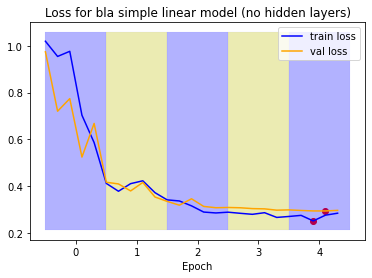

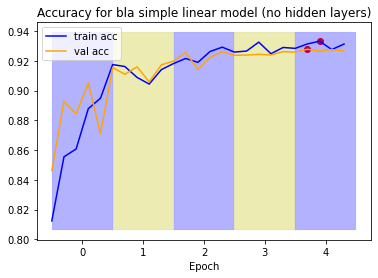

In [163]:
test_loss, test_acc = evaluate(lin_bla, test_data)
print(f'Evaluation on the test set: loss={test_loss:.3f} accuracy={test_acc:.3f}')
plot_loss_and_accuracy(lin_hist_bla, lin_bla)

In [101]:
dim_input = 28*28
dim_output = 10

linear_network_vanilla = LinearNetwork(dim_input, dim_output, name = "vanilla")
optimizer_vanilla = SGD(linear_network_vanilla.parameters(), 0.01, lrDecay = False)
linear_history_vanilla = training_loop(linear_network_vanilla, optimizer_vanilla, train_data, dev_data, n_epochs=5)

linear_network_lr_decay = LinearNetwork(dim_input, dim_output, name = "with learning rate decay")
optimizer_lr_decay = SGD(linear_network_lr_decay.parameters(), 0.01, lrDecay = True)
linear_history_lr_decay = training_loop(linear_network_lr_decay, optimizer_lr_decay, train_data, dev_data, n_epochs=5)


  0%|          | 0/5 [00:00<?, ?it/s]

In [102]:
test_loss, test_acc = evaluate(linear_network_lr_decay, test_data)
print(f'Evaluation on the test set: loss={test_loss:.3f} accuracy={test_acc:.3f}')
test_loss, test_acc = evaluate(linear_network_vanilla, test_data)
print(f'Evaluation on the test set: loss={test_loss:.3f} accuracy={test_acc:.3f}')

Evaluation on the test set: loss=0.276 accuracy=0.921
Evaluation on the test set: loss=0.277 accuracy=0.923


In [209]:
linear_histories.keys()

dict_keys(['using momentum SGD_lr:1.0', 'using momentum SGD_lr:0.1', 'using momentum SGD_lr:0.01', 'using momentum SGD_lr:0.001', 'using momentum SGD_lr:0.0001', 'using momentum SGD_lr:1e-05', 'using momentum SGD_lr:1e-06', 'using momentum SGD_lr:1e-07', 'vanilla_lr:1.0', 'vanilla_lr:0.1', 'vanilla_lr:0.01', 'vanilla_lr:0.001', 'vanilla_lr:0.0001', 'vanilla_lr:1e-05', 'vanilla_lr:1e-06', 'vanilla_lr:1e-07', 'using lr decay and momentum SGD_lr:1.0', 'using lr decay and momentum SGD_lr:0.1', 'using lr decay and momentum SGD_lr:0.01', 'using lr decay and momentum SGD_lr:0.001', 'using lr decay and momentum SGD_lr:0.0001', 'using lr decay and momentum SGD_lr:1e-05', 'using lr decay and momentum SGD_lr:1e-06', 'using lr decay and momentum SGD_lr:1e-07', 'using lr decay_lr:1.0', 'using lr decay_lr:0.1', 'using lr decay_lr:0.01', 'using lr decay_lr:0.001', 'using lr decay_lr:0.0001', 'using lr decay_lr:1e-05', 'using lr decay_lr:1e-06', 'using lr decay_lr:1e-07'])

In [293]:
#makeDF(deep_histories_neurons_per_layer)
makeDFNeuronsPerLayer(deep_histories_neurons_per_layer)

,momentum,using_decay,neuronsPerLayer,test_acc,time_til_conv,relu
0,1,1,5,0.8939,6,True
1,1,1,5,0.8699,12,False
2,1,1,50,0.9745,6,True
3,1,1,50,0.9702,5,False
4,1,1,100,0.9766,5,True
5,1,1,100,0.9752,8,False


In [292]:
def makeDFNeuronsPerLayer(histories):
    d = []
    for k in histories.keys():
        row = {}
        if "momentum" in k:
            row["momentum"] = 1
        else:
            row["momentum"] = 0
        if "decay" in k:
            row["using_decay"] = 1
        else:
            row["using_decay"] = 0
        row["neuronsPerLayer"] = k.split("_")[1]
        row["test_acc"] = getTestAcc(histories[k])
        row["time_til_conv"] = time_til_conversion(histories[k])
        row["relu"] = "relu" in k
        d.append(row)
    
    return pd.DataFrame(d)

def makeDF(histories):
    d = []
    for k in histories.keys():
        row = {}
        if "momentum" in k:
            row["momentum"] = 1
        else:
            row["momentum"] = 0
        if "decay" in k:
            row["using_decay"] = 1
        else:
            row["using_decay"] = 0
        row["lr"] = k.split(":")[1]
        row["test_acc"] = getTestAcc(histories[k])
        row["time_til_conv"] = time_til_conversion(histories[k])
        d.append(row)
    
    return pd.DataFrame(d)

0.9237


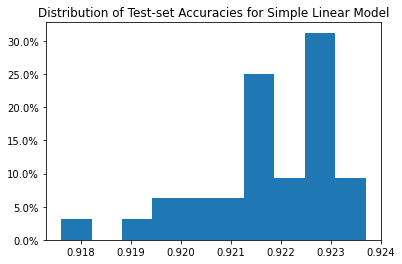

In [207]:
accuracy_histogram(linear_histories)

In [225]:
def getTestAcc(hist):
    maxVal = hist[0]["acc_test"][np.argmax(hist[0]["acc_val"])]
    return maxVal
def accuracy_histogram(histories):
    maxVals = []
    for k in histories.keys():
        hist = histories[k]
        maxVal = getTestAcc(hist)
        maxVals.append(maxVal)
    plt.hist(maxVals,weights=np.ones(len(maxVals)) / len(maxVals))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title("Distribution of Test-set Accuracies for Simple Linear Model")
    

In [191]:
def test_on_best_dev_epoch(histories):
    for k in histories.keys():
        hist = histories[k]
        max_validation_index = np.argmax(hist[0]["acc_val"])
        

In [266]:
dfLinHist

,momentum,using_decay,lr,test_acc,time_til_conv
0,1,0,1.0,0.9206,2
1,1,0,0.1,0.9229,4
2,1,0,0.01,0.9207,3
3,1,0,0.001,0.9218,4
4,1,0,0.0001,0.9176,2
5,1,0,1e-05,0.9217,4
6,1,0,1e-06,0.9215,5
7,1,0,1e-07,0.9199,5
8,0,0,1.0,0.9195,5
9,0,0,0.1,0.9192,5


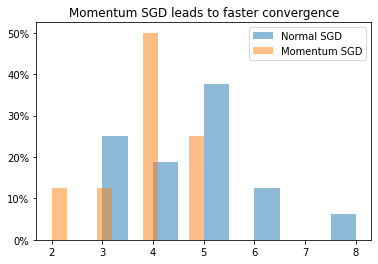

In [285]:
dfLinHist = makeDF(linear_histories)
plotTimeTilConversion(dfLinHist)

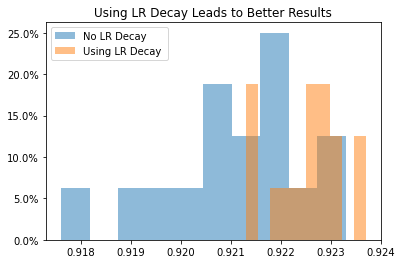

In [275]:
histTestAccByUsingDecayLR(dfLinHist)

In [274]:
def histTestAccByUsingDecayLR(df):
    df = df.sort_values("using_decay")
    plt.hist(df[df.using_decay==0].test_acc,alpha=0.5,label="No LR Decay",weights=np.ones(len(df[df.using_decay==0].test_acc)) / len(df[df.using_decay==0].test_acc))
    plt.hist(df[df.using_decay==1].test_acc,alpha=0.5,label="Using LR Decay ",weights=np.ones(len(df[df.using_decay==1].test_acc)) / len(df[df.using_decay==1].test_acc))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend()
    plt.title("Using LR Decay Leads to Better Results")

def plotTimeTilConversion(df):
    df = df.sort_values("time_til_conv")
    plt.hist(df[df.momentum==0].time_til_conv,alpha=0.5,label="Normal SGD",weights=np.ones(len(df[df.momentum==0].time_til_conv)) / len(df[df.momentum==0].time_til_conv))
    plt.hist(df[df.momentum==1].time_til_conv,alpha=0.5,label="Momentum SGD",weights=np.ones(len(df[df.momentum==1].time_til_conv)) / len(df[df.momentum==1].time_til_conv))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    pearsonr(dfLinHist.momentum, dfLinHist.time_til_conv)
    plt.legend()
    plt.title("Momentum SGD leads to faster convergence")

def time_til_conversion(hist):
    acc_val = hist[0]["acc_val"]
    best_acc_val = np.max(acc_val)
    #number of iterations until within 1% of best validation accuracy
    percDiffs = [100*(best_acc_val-x)/best_acc_val for x in acc_val]
    percDiffsLessThanThresh = [x < 1 for x in percDiffs]
    firstIterationWithinThreshold = np.arange(len(percDiffsLessThanThresh))[percDiffsLessThanThresh].min()
    return firstIterationWithinThreshold

In [188]:
dim_input = 28*28
dim_output = 10

for do_lr_decay in (False, True):
    for do_momentum_SGD in (True, False):
        for initial_lr in 1/np.power(10,np.arange(0,8)):
            if do_momentum_SGD:
                Opt = MomtenumSGD
            else:
                Opt = SGD
            if do_lr_decay:
                name = "using lr decay"
                if do_momentum_SGD:
                    name += " and momentum SGD"
            elif do_momentum_SGD:
                name = "using momentum SGD"
            else:
                name = "vanilla"
            name += "_lr:" + str(initial_lr)
            if name in linear_histories:
                print("skipping",name)
                continue;
            print("training on",name)
            linear_network = LinearNetwork(dim_input, dim_output, name=name)
            linear_optimizer = Opt(linear_network.parameters(), 0.01, lrDecay = do_lr_decay)
            linear_history = training_loop(linear_network, linear_optimizer, train_data, dev_data, n_epochs=5)
            linear_histories[name] = (linear_history, linear_network)
        

training on using momentum SGD_lr:1.0


  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.33607653635230655 and accuracy 0.907
current test loss 0.34059022405568473 and accuracy 0.9086
current loss 0.3195617983411622 and accuracy 0.9111
current test loss 0.32662414262854245 and accuracy 0.9057
current loss 0.2963942688080773 and accuracy 0.9162
current test loss 0.31299543634911187 and accuracy 0.9124
current loss 0.3042979428260253 and accuracy 0.9138
current test loss 0.3177100696278057 and accuracy 0.9081
current loss 0.29210396121017773 and accuracy 0.9164
current test loss 0.29885586136540904 and accuracy 0.9154
current loss 0.28495021906924245 and accuracy 0.92
current test loss 0.2950181158059006 and accuracy 0.9171
current loss 0.2950287429302945 and accuracy 0.9154
current test loss 0.30232591410847315 and accuracy 0.9151
current loss 0.3075051297385226 and accuracy 0.9122
current test loss 0.328124995481182 and accuracy 0.9083
current loss 0.2788231748848552 and accuracy 0.9222
current test loss 0.29207156193868566 and accuracy 0.9168
current loss 0

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.35806250668541856 and accuracy 0.8986
current test loss 0.36344305722843934 and accuracy 0.8949
current loss 0.30869504370101114 and accuracy 0.9122
current test loss 0.3078336071280612 and accuracy 0.9129
current loss 0.30420135021974143 and accuracy 0.9133
current test loss 0.31233788353092334 and accuracy 0.909
current loss 0.3014337975076242 and accuracy 0.9123
current test loss 0.30713647747916195 and accuracy 0.9131
current loss 0.29231922607292876 and accuracy 0.9173
current test loss 0.29847845469913065 and accuracy 0.9136
current loss 0.29202878395969745 and accuracy 0.9165
current test loss 0.2925474484877719 and accuracy 0.9172
current loss 0.28774047544939346 and accuracy 0.9185
current test loss 0.2986507176709014 and accuracy 0.9147
current loss 0.2968488295950917 and accuracy 0.9146
current test loss 0.3067321139147126 and accuracy 0.9129
current loss 0.2757977921687041 and accuracy 0.9231
current test loss 0.2819566819905881 and accuracy 0.9199
current lo

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3833373802024281 and accuracy 0.8811
current test loss 0.3837260950183264 and accuracy 0.8857
current loss 0.3216620153024265 and accuracy 0.9096
current test loss 0.3325932736141171 and accuracy 0.9038
current loss 0.3247818820445285 and accuracy 0.9056
current test loss 0.33340739016042187 and accuracy 0.9028
current loss 0.2995107390959684 and accuracy 0.9173
current test loss 0.3026657348707267 and accuracy 0.9139
current loss 0.2905291971056228 and accuracy 0.9202
current test loss 0.296528937259067 and accuracy 0.9193
current loss 0.2835702131992564 and accuracy 0.9191
current test loss 0.29659177722873586 and accuracy 0.9156
current loss 0.28722049507322617 and accuracy 0.9182
current test loss 0.2944562335315352 and accuracy 0.916
current loss 0.28761330974617944 and accuracy 0.9176
current test loss 0.2962931801462411 and accuracy 0.915
current loss 0.2856946984617668 and accuracy 0.9211
current test loss 0.2899433003989492 and accuracy 0.918
current loss 0.2744

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3655032213425559 and accuracy 0.8934
current test loss 0.37833375441034955 and accuracy 0.8877
current loss 0.32003272074825045 and accuracy 0.9109
current test loss 0.33352795713086053 and accuracy 0.9063
current loss 0.3191087219695056 and accuracy 0.9085
current test loss 0.32501092423517763 and accuracy 0.908
current loss 0.2990700697152888 and accuracy 0.9163
current test loss 0.31440534113432583 and accuracy 0.9087
current loss 0.28601489197412855 and accuracy 0.9193
current test loss 0.2965231319580088 and accuracy 0.9165
current loss 0.2879951659121993 and accuracy 0.9214
current test loss 0.29477897829120636 and accuracy 0.9161
current loss 0.28823085617563654 and accuracy 0.9205
current test loss 0.29814616289816864 and accuracy 0.9164
current loss 0.2809558610807644 and accuracy 0.9215
current test loss 0.2903510579612183 and accuracy 0.9187
current loss 0.29744490290410436 and accuracy 0.9147
current test loss 0.31078997030473243 and accuracy 0.9112
current l

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3548324005196881 and accuracy 0.8979
current test loss 0.35498617220392203 and accuracy 0.8976
current loss 0.3154628991617331 and accuracy 0.9114
current test loss 0.31930566194155857 and accuracy 0.9098
current loss 0.2936024300120013 and accuracy 0.9183
current test loss 0.30083894948051787 and accuracy 0.9155
current loss 0.2951791972374424 and accuracy 0.9181
current test loss 0.29788873561162577 and accuracy 0.9173
current loss 0.2945023744730116 and accuracy 0.9154
current test loss 0.30595911685475263 and accuracy 0.9124
current loss 0.2934474073899377 and accuracy 0.9176
current test loss 0.30421025212816055 and accuracy 0.912
current loss 0.29079401555618717 and accuracy 0.9151
current test loss 0.2969438767452685 and accuracy 0.9176
current loss 0.2821644305267282 and accuracy 0.9211
current test loss 0.2925713807961453 and accuracy 0.9193
current loss 0.2855657622866016 and accuracy 0.9218
current test loss 0.29569611774515603 and accuracy 0.9159
current loss

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3415321342581141 and accuracy 0.9056
current test loss 0.34505553367584624 and accuracy 0.9014
current loss 0.3206432784323915 and accuracy 0.9074
current test loss 0.3256372311884993 and accuracy 0.909
current loss 0.3077372732306075 and accuracy 0.9123
current test loss 0.3134104212621107 and accuracy 0.911
current loss 0.3077503622881995 and accuracy 0.9121
current test loss 0.3152534240091848 and accuracy 0.9096
current loss 0.2906510900942395 and accuracy 0.9172
current test loss 0.29737759803279384 and accuracy 0.9168
current loss 0.2840434934811767 and accuracy 0.9194
current test loss 0.2932047222604136 and accuracy 0.9171
current loss 0.28797277362631996 and accuracy 0.9196
current test loss 0.29813421710138377 and accuracy 0.9169
current loss 0.2893216847832596 and accuracy 0.9191
current test loss 0.30506111147196574 and accuracy 0.9152
current loss 0.28512012884619353 and accuracy 0.9205
current test loss 0.29369671779756756 and accuracy 0.917
current loss 0.

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3497520936920697 and accuracy 0.8997
current test loss 0.36146562948928124 and accuracy 0.8946
current loss 0.31267032201829753 and accuracy 0.9102
current test loss 0.3251560954507948 and accuracy 0.9053
current loss 0.3064649298575747 and accuracy 0.9153
current test loss 0.3145597640940467 and accuracy 0.9114
current loss 0.30811899985984653 and accuracy 0.9118
current test loss 0.31804736395406014 and accuracy 0.9111
current loss 0.29871955866923644 and accuracy 0.9147
current test loss 0.2976696427164005 and accuracy 0.915
current loss 0.2939770917093788 and accuracy 0.9169
current test loss 0.2981880778892476 and accuracy 0.9159
current loss 0.3022910454385196 and accuracy 0.9137
current test loss 0.31251015896954343 and accuracy 0.9105
current loss 0.2845828274116026 and accuracy 0.9191
current test loss 0.3015948103301913 and accuracy 0.9146
current loss 0.2744295308569426 and accuracy 0.9231
current test loss 0.2868026536809119 and accuracy 0.919
current loss 0.

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.352588278932504 and accuracy 0.9016
current test loss 0.36065086821467063 and accuracy 0.8996
current loss 0.3295617999763866 and accuracy 0.9085
current test loss 0.33554809879816977 and accuracy 0.9008
current loss 0.3149962221425061 and accuracy 0.9118
current test loss 0.31088660420206327 and accuracy 0.9125
current loss 0.3037861424837615 and accuracy 0.9144
current test loss 0.31866455307513536 and accuracy 0.9095
current loss 0.32435974894127895 and accuracy 0.906
current test loss 0.3346362658787808 and accuracy 0.9046
current loss 0.29481245904817444 and accuracy 0.9177
current test loss 0.30613780857233885 and accuracy 0.9148
current loss 0.28343768530995267 and accuracy 0.923
current test loss 0.29625683580586637 and accuracy 0.9174
current loss 0.29895727692247104 and accuracy 0.914
current test loss 0.31223721195714 and accuracy 0.9103
current loss 0.28752772117913594 and accuracy 0.9185
current test loss 0.2903158849148687 and accuracy 0.9178
current loss 0

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3617925687070349 and accuracy 0.8958
current test loss 0.3703514552382172 and accuracy 0.8933
current loss 0.3239123751497467 and accuracy 0.9063
current test loss 0.33122777781269586 and accuracy 0.9049
current loss 0.3201333407062918 and accuracy 0.9043
current test loss 0.32796384102858733 and accuracy 0.9073
current loss 0.3391919424353456 and accuracy 0.9024
current test loss 0.33250312151135625 and accuracy 0.9028
current loss 0.30023315052450605 and accuracy 0.9141
current test loss 0.3127634136008972 and accuracy 0.9114
current loss 0.29305359403082404 and accuracy 0.9187
current test loss 0.29776035531501666 and accuracy 0.914
current loss 0.290594432464698 and accuracy 0.918
current test loss 0.2972784433226462 and accuracy 0.9171
current loss 0.2859723883900037 and accuracy 0.9187
current test loss 0.29430958512040384 and accuracy 0.9164
current loss 0.27670031074990203 and accuracy 0.9228
current test loss 0.28776525243057965 and accuracy 0.9178
current loss 

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.33198244691999595 and accuracy 0.9069
current test loss 0.34924292403104257 and accuracy 0.8989
current loss 0.332683023852677 and accuracy 0.9046
current test loss 0.33550213060135864 and accuracy 0.9049
current loss 0.2997119439337326 and accuracy 0.9159
current test loss 0.31684115508041605 and accuracy 0.9085
current loss 0.2981556187445189 and accuracy 0.9159
current test loss 0.3049593378621098 and accuracy 0.9143
current loss 0.3216322011375896 and accuracy 0.9053
current test loss 0.33883153351639583 and accuracy 0.9004
current loss 0.2863789562400348 and accuracy 0.9196
current test loss 0.2913549351328569 and accuracy 0.9199
current loss 0.2888162733782654 and accuracy 0.9179
current test loss 0.30288689441255606 and accuracy 0.9157
current loss 0.2806263212184597 and accuracy 0.919
current test loss 0.2927795956275456 and accuracy 0.9151
current loss 0.28470539655180155 and accuracy 0.9204
current test loss 0.29556198184619065 and accuracy 0.9132
current loss 

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3505272263817831 and accuracy 0.8996
current test loss 0.3671878649948071 and accuracy 0.8955
current loss 0.3133746242038792 and accuracy 0.9117
current test loss 0.32340380739518865 and accuracy 0.9046
current loss 0.32563613300751815 and accuracy 0.905
current test loss 0.3327951377182337 and accuracy 0.9001
current loss 0.3207105373494277 and accuracy 0.9087
current test loss 0.3240769768693375 and accuracy 0.9069
current loss 0.32183872786826984 and accuracy 0.9063
current test loss 0.33032809521298456 and accuracy 0.9052
current loss 0.2884257994553404 and accuracy 0.9185
current test loss 0.29709266075219914 and accuracy 0.9169
current loss 0.30099713708716297 and accuracy 0.9157
current test loss 0.31499260817503555 and accuracy 0.9099
current loss 0.28643536377137224 and accuracy 0.9193
current test loss 0.2910446393012854 and accuracy 0.9182
current loss 0.28081645941912525 and accuracy 0.9208
current test loss 0.29055687081463 and accuracy 0.9147
current loss 

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3442491322518791 and accuracy 0.9045
current test loss 0.3527339499896934 and accuracy 0.8993
current loss 0.3185326329861083 and accuracy 0.9077
current test loss 0.3374330486635138 and accuracy 0.9011
current loss 0.3017853158815718 and accuracy 0.9137
current test loss 0.3111590059881523 and accuracy 0.9129
current loss 0.3041948244460383 and accuracy 0.9153
current test loss 0.31370407474575446 and accuracy 0.9121
current loss 0.2841976786549457 and accuracy 0.9173
current test loss 0.2972073721436067 and accuracy 0.916
current loss 0.2944769896651589 and accuracy 0.9145
current test loss 0.3060721360499008 and accuracy 0.9136
current loss 0.2912592807346295 and accuracy 0.9166
current test loss 0.30267692728822376 and accuracy 0.9148
current loss 0.2961607510180063 and accuracy 0.9171
current test loss 0.3022309509895258 and accuracy 0.9181
current loss 0.27551364269204115 and accuracy 0.9206
current test loss 0.289190450752584 and accuracy 0.9182
current loss 0.280

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3389425155458177 and accuracy 0.9063
current test loss 0.3488523023696354 and accuracy 0.8988
current loss 0.31374887686756214 and accuracy 0.9119
current test loss 0.32188209211189217 and accuracy 0.9087
current loss 0.31736136154184297 and accuracy 0.9114
current test loss 0.3250071817058456 and accuracy 0.9076
current loss 0.29401527395137284 and accuracy 0.9169
current test loss 0.30144661814391754 and accuracy 0.9128
current loss 0.2967633887650794 and accuracy 0.9159
current test loss 0.30616708860682995 and accuracy 0.9127
current loss 0.2937113444680504 and accuracy 0.9165
current test loss 0.3030410407708375 and accuracy 0.9156
current loss 0.2929217615427384 and accuracy 0.9152
current test loss 0.2993043497650996 and accuracy 0.9169
current loss 0.27410697159620717 and accuracy 0.9232
current test loss 0.28562585176178784 and accuracy 0.9189
current loss 0.2860334854156335 and accuracy 0.9183
current test loss 0.2940892672274979 and accuracy 0.9115
current los

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3498225353402799 and accuracy 0.8993
current test loss 0.3600675402805767 and accuracy 0.8967
current loss 0.3195119816090664 and accuracy 0.91
current test loss 0.32827295074585955 and accuracy 0.9068
current loss 0.29820949081102754 and accuracy 0.9149
current test loss 0.307571407595942 and accuracy 0.9131
current loss 0.29732461515436254 and accuracy 0.9167
current test loss 0.3088043703798634 and accuracy 0.9138
current loss 0.295514640212251 and accuracy 0.9178
current test loss 0.30217832049797233 and accuracy 0.9157
current loss 0.2970096441540416 and accuracy 0.918
current test loss 0.30079288993144776 and accuracy 0.9165
current loss 0.2850636033353073 and accuracy 0.9198
current test loss 0.2901004266827941 and accuracy 0.9163
current loss 0.2899652017131648 and accuracy 0.9174
current test loss 0.30129493445844985 and accuracy 0.9158
current loss 0.29682332184304805 and accuracy 0.9154
current test loss 0.31197000797479657 and accuracy 0.9101
current loss 0.2

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.35023306858691355 and accuracy 0.9027
current test loss 0.35781034278566914 and accuracy 0.8993
current loss 0.309712878568024 and accuracy 0.9134
current test loss 0.32805869252159675 and accuracy 0.9087
current loss 0.30373822230176695 and accuracy 0.9139
current test loss 0.3064539100949496 and accuracy 0.9131
current loss 0.314775806430392 and accuracy 0.9076
current test loss 0.3228744022866513 and accuracy 0.9052
current loss 0.31063094247986917 and accuracy 0.9109
current test loss 0.3214424103952579 and accuracy 0.9073
current loss 0.2971189751510024 and accuracy 0.9166
current test loss 0.3054698133954651 and accuracy 0.9152
current loss 0.2825108517720905 and accuracy 0.9202
current test loss 0.2931794112287709 and accuracy 0.9167
current loss 0.28537700999476084 and accuracy 0.9189
current test loss 0.29508779579590455 and accuracy 0.9159
current loss 0.293708213530558 and accuracy 0.9181
current test loss 0.30237524437292357 and accuracy 0.9146
current loss 0

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3485660895872906 and accuracy 0.9028
current test loss 0.358755822357494 and accuracy 0.8986
current loss 0.3152522200813063 and accuracy 0.9109
current test loss 0.32816892576222884 and accuracy 0.9056
current loss 0.30929537959509473 and accuracy 0.9113
current test loss 0.3098902020428256 and accuracy 0.9108
current loss 0.29358986452050545 and accuracy 0.9188
current test loss 0.30100401400877436 and accuracy 0.9161
current loss 0.28370236899077295 and accuracy 0.9205
current test loss 0.29317132720830036 and accuracy 0.9181
current loss 0.2874762660794544 and accuracy 0.9189
current test loss 0.291212721319492 and accuracy 0.9182
current loss 0.3075177620652069 and accuracy 0.9118
current test loss 0.3112369648082721 and accuracy 0.9106
current loss 0.28196714705972103 and accuracy 0.9227
current test loss 0.29638049509942055 and accuracy 0.9183
current loss 0.2790509733921885 and accuracy 0.9222
current test loss 0.29161244838325434 and accuracy 0.9183
current loss

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.38055379308283743 and accuracy 0.885
current test loss 0.3840032972835442 and accuracy 0.8849
current loss 0.3410638857646119 and accuracy 0.8972
current test loss 0.35223024095153443 and accuracy 0.8918
current loss 0.31449466816171423 and accuracy 0.9076
current test loss 0.3177444490727081 and accuracy 0.9087
current loss 0.3072157710945333 and accuracy 0.9122
current test loss 0.3138446698823619 and accuracy 0.9094
current loss 0.29515907444796496 and accuracy 0.9191
current test loss 0.3078502143072126 and accuracy 0.9142
current loss 0.29183155752160306 and accuracy 0.917
current test loss 0.309767102283112 and accuracy 0.9138
current loss 0.27910945800751713 and accuracy 0.9226
current test loss 0.28935835078143207 and accuracy 0.918
current loss 0.29159667018236596 and accuracy 0.9181
current test loss 0.31101284437260573 and accuracy 0.9132
triggering lr decay
current loss 0.27222047017836226 and accuracy 0.9245
current test loss 0.28090137331445947 and accuracy

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3537176072234336 and accuracy 0.8996
current test loss 0.36333031399183163 and accuracy 0.8978
current loss 0.3211712248817578 and accuracy 0.9089
current test loss 0.32963763913551186 and accuracy 0.9058
current loss 0.3092368086783692 and accuracy 0.9109
current test loss 0.3142965695365923 and accuracy 0.9092
current loss 0.3024336118074745 and accuracy 0.9134
current test loss 0.30722074458925214 and accuracy 0.9118
current loss 0.28694537792484326 and accuracy 0.9179
current test loss 0.3036604747607374 and accuracy 0.912
current loss 0.2938559362323958 and accuracy 0.9188
current test loss 0.29850734978561844 and accuracy 0.9147
triggering lr decay
current loss 0.28152961496871826 and accuracy 0.9199
current test loss 0.2855920998882316 and accuracy 0.919
current loss 0.2815026648188431 and accuracy 0.921
current test loss 0.28856556065403366 and accuracy 0.9172
current loss 0.2796751325544822 and accuracy 0.9209
current test loss 0.2902826126797767 and accuracy 0.

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3381424294056799 and accuracy 0.9036
current test loss 0.3485012247849464 and accuracy 0.902
current loss 0.3278060419370942 and accuracy 0.9065
current test loss 0.3345511671297836 and accuracy 0.9053
current loss 0.30845436678660954 and accuracy 0.9109
current test loss 0.3146209141703589 and accuracy 0.9118
current loss 0.33358503440040815 and accuracy 0.9036
current test loss 0.3299712683245613 and accuracy 0.9056
triggering lr decay
current loss 0.28868652856884275 and accuracy 0.9195
current test loss 0.29569456744767564 and accuracy 0.9189
current loss 0.2880429847734548 and accuracy 0.9171
current test loss 0.29149601661938995 and accuracy 0.9181
current loss 0.28196466645518853 and accuracy 0.9206
current test loss 0.2913877620308507 and accuracy 0.9197
current loss 0.28246100077209385 and accuracy 0.9201
current test loss 0.2901033451153715 and accuracy 0.9175
triggering lr decay
current loss 0.2721486582186375 and accuracy 0.9237
current test loss 0.2802160536

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3494318322443051 and accuracy 0.901
current test loss 0.36462642681622426 and accuracy 0.8954
current loss 0.33631912749948856 and accuracy 0.9038
current test loss 0.34475000261386096 and accuracy 0.9
current loss 0.3106348347530269 and accuracy 0.9112
current test loss 0.31868207408839483 and accuracy 0.9099
current loss 0.30681212134570984 and accuracy 0.9134
current test loss 0.3144732629018371 and accuracy 0.9108
current loss 0.2879907347271907 and accuracy 0.9178
current test loss 0.3012224956018794 and accuracy 0.9163
current loss 0.2835311720926363 and accuracy 0.9188
current test loss 0.29453728864168105 and accuracy 0.9166
current loss 0.287652593059479 and accuracy 0.9185
current test loss 0.2885014324804166 and accuracy 0.9178
triggering lr decay
current loss 0.2787442977320457 and accuracy 0.9204
current test loss 0.2890314130966094 and accuracy 0.9203
current loss 0.2740451532171196 and accuracy 0.9225
current test loss 0.28153372477537386 and accuracy 0.91

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3472356799570956 and accuracy 0.8996
current test loss 0.35513338121700433 and accuracy 0.8986
current loss 0.31870773406260944 and accuracy 0.9108
current test loss 0.3258219051389115 and accuracy 0.9061
current loss 0.3015689462197246 and accuracy 0.9136
current test loss 0.30472873381087595 and accuracy 0.914
current loss 0.30422596641499255 and accuracy 0.9156
current test loss 0.3139223448507813 and accuracy 0.9108
triggering lr decay
current loss 0.28485975381885725 and accuracy 0.9199
current test loss 0.29188323779346687 and accuracy 0.9171
current loss 0.2832584767350594 and accuracy 0.9213
current test loss 0.2915790624843202 and accuracy 0.9166
current loss 0.2845795479722791 and accuracy 0.9194
current test loss 0.2919778061471232 and accuracy 0.9171
triggering lr decay
current loss 0.27915844596580275 and accuracy 0.9191
current test loss 0.2858135201666164 and accuracy 0.918
current loss 0.27798353657652836 and accuracy 0.9214
current test loss 0.2882936266

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.36084395408925257 and accuracy 0.8941
current test loss 0.3717094635172818 and accuracy 0.8898
current loss 0.31349106797270415 and accuracy 0.9121
current test loss 0.3221645943864359 and accuracy 0.9083
current loss 0.3200271277859959 and accuracy 0.908
current test loss 0.324167258008508 and accuracy 0.9065
triggering lr decay
current loss 0.2940513526132256 and accuracy 0.9174
current test loss 0.2974023990205894 and accuracy 0.9158
current loss 0.28933555263204114 and accuracy 0.9162
current test loss 0.2955260908852285 and accuracy 0.9152
current loss 0.29712070509965477 and accuracy 0.9154
current test loss 0.30460253890099537 and accuracy 0.9103
triggering lr decay
current loss 0.28268327640176744 and accuracy 0.9193
current test loss 0.2886561727904671 and accuracy 0.9202
current loss 0.2782258484423109 and accuracy 0.9214
current test loss 0.2876037156583605 and accuracy 0.9192
current loss 0.2783764307801891 and accuracy 0.922
current test loss 0.2861127826685

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3666198838821434 and accuracy 0.8944
current test loss 0.36891889757591184 and accuracy 0.895
current loss 0.30931739081219467 and accuracy 0.9133
current test loss 0.3184159357122046 and accuracy 0.9076
current loss 0.3046367177112511 and accuracy 0.9109
current test loss 0.31431301287963137 and accuracy 0.9102
current loss 0.3101319326949623 and accuracy 0.9088
current test loss 0.31216365102495214 and accuracy 0.9131
triggering lr decay
current loss 0.28858227778181866 and accuracy 0.9187
current test loss 0.29883854519786063 and accuracy 0.9129
current loss 0.2863560068030578 and accuracy 0.9204
current test loss 0.2974597209344139 and accuracy 0.9163
current loss 0.2810958900514102 and accuracy 0.9208
current test loss 0.29311747347798733 and accuracy 0.9188
current loss 0.2820610067656391 and accuracy 0.9188
current test loss 0.28852229871971896 and accuracy 0.9176
triggering lr decay
current loss 0.2756059195482504 and accuracy 0.9225
current test loss 0.283331448

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3478630050948521 and accuracy 0.9011
current test loss 0.3518961205317504 and accuracy 0.9035
current loss 0.31514895510581 and accuracy 0.9106
current test loss 0.31596659065323374 and accuracy 0.9103
current loss 0.31463211261518426 and accuracy 0.908
current test loss 0.3247272519582125 and accuracy 0.9076
current loss 0.2986032065520631 and accuracy 0.9161
current test loss 0.3097258725891304 and accuracy 0.9109
current loss 0.29983800539107314 and accuracy 0.9133
current test loss 0.31073757775822103 and accuracy 0.909
triggering lr decay
current loss 0.28204609365583866 and accuracy 0.9203
current test loss 0.292216236205795 and accuracy 0.9174
current loss 0.2774999181847448 and accuracy 0.9232
current test loss 0.28315802090241576 and accuracy 0.9191
current loss 0.27604405740835175 and accuracy 0.9215
current test loss 0.2835829636265162 and accuracy 0.9209
current loss 0.2791762366543678 and accuracy 0.9213
current test loss 0.28713020291810365 and accuracy 0.9

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.36990889519195497 and accuracy 0.8921
current test loss 0.386060495562539 and accuracy 0.8881
current loss 0.3202712224440632 and accuracy 0.9115
current test loss 0.3355651999615898 and accuracy 0.9038
current loss 0.30458370610069907 and accuracy 0.9138
current test loss 0.3133109528152495 and accuracy 0.9122
current loss 0.30297368529901514 and accuracy 0.915
current test loss 0.3102425338138714 and accuracy 0.9111
current loss 0.28872706762240274 and accuracy 0.9178
current test loss 0.2974897912497392 and accuracy 0.9127
current loss 0.28371378284803106 and accuracy 0.9193
current test loss 0.2878039022248554 and accuracy 0.9194
current loss 0.2952677885485596 and accuracy 0.9183
current test loss 0.29950224349770277 and accuracy 0.9142
triggering lr decay
current loss 0.2809534408903367 and accuracy 0.9205
current test loss 0.28946430730305084 and accuracy 0.9179
current loss 0.27894547657428936 and accuracy 0.921
current test loss 0.29057940488692335 and accuracy 

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.35277240102480834 and accuracy 0.9014
current test loss 0.35788656015887865 and accuracy 0.8997
current loss 0.31994134657779416 and accuracy 0.9077
current test loss 0.3260113354567472 and accuracy 0.9071
current loss 0.30563803009625273 and accuracy 0.9149
current test loss 0.3138017836517098 and accuracy 0.9118
current loss 0.30539248814935793 and accuracy 0.9141
current test loss 0.3051693660843124 and accuracy 0.913
current loss 0.2923894505011905 and accuracy 0.9171
current test loss 0.3004266028034669 and accuracy 0.9158
current loss 0.29361324184212706 and accuracy 0.917
current test loss 0.2968784545483029 and accuracy 0.9181
triggering lr decay
current loss 0.2788670205792526 and accuracy 0.9246
current test loss 0.28761188341986915 and accuracy 0.9199
current loss 0.28500269417438956 and accuracy 0.9205
current test loss 0.29391683053520673 and accuracy 0.9152
triggering lr decay
current loss 0.27475616984703555 and accuracy 0.923
current test loss 0.282802678

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3590677747473258 and accuracy 0.8973
current test loss 0.36790780438540394 and accuracy 0.8967
current loss 0.33174844461598396 and accuracy 0.9063
current test loss 0.328596244980715 and accuracy 0.9041
current loss 0.3052620968760867 and accuracy 0.9114
current test loss 0.3159534953836193 and accuracy 0.9084
current loss 0.2917467642196478 and accuracy 0.9182
current test loss 0.29606367445396203 and accuracy 0.9142
current loss 0.29657880323970814 and accuracy 0.916
current test loss 0.3090082676000509 and accuracy 0.9107
triggering lr decay
current loss 0.28233329360827314 and accuracy 0.9209
current test loss 0.2899748685247261 and accuracy 0.9169
current loss 0.2871637992728524 and accuracy 0.9177
current test loss 0.2921144956549575 and accuracy 0.9164
triggering lr decay
current loss 0.27448293690115516 and accuracy 0.923
current test loss 0.2820138275319554 and accuracy 0.9181
current loss 0.2745150242879279 and accuracy 0.9226
current test loss 0.2815670570286

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.33827690207150923 and accuracy 0.9049
current test loss 0.3480112707405251 and accuracy 0.9027
current loss 0.3306466221925644 and accuracy 0.9048
current test loss 0.3409838930018687 and accuracy 0.9036
current loss 0.31534103848654677 and accuracy 0.911
current test loss 0.3180658394487933 and accuracy 0.9076
current loss 0.2962172474210443 and accuracy 0.9161
current test loss 0.3010777114305374 and accuracy 0.9135
current loss 0.29834291955608344 and accuracy 0.9131
current test loss 0.3051541101950976 and accuracy 0.9103
triggering lr decay
current loss 0.2803124710618726 and accuracy 0.9207
current test loss 0.2856440994641469 and accuracy 0.9173
current loss 0.27834303423718443 and accuracy 0.9214
current test loss 0.28458435759817075 and accuracy 0.9201
current loss 0.2837397702073949 and accuracy 0.9204
current test loss 0.2866192111936714 and accuracy 0.9187
triggering lr decay
current loss 0.2755486023905225 and accuracy 0.9231
current test loss 0.283447830488

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3678975536959056 and accuracy 0.8925
current test loss 0.37547902551890205 and accuracy 0.8907
current loss 0.3196067857249242 and accuracy 0.9062
current test loss 0.3310988710510273 and accuracy 0.903
current loss 0.35422329374363765 and accuracy 0.8972
current test loss 0.36158016324114906 and accuracy 0.8964
triggering lr decay
current loss 0.29235238165243527 and accuracy 0.9181
current test loss 0.30237561257125856 and accuracy 0.9145
current loss 0.2900696088100905 and accuracy 0.9177
current test loss 0.29490981931073545 and accuracy 0.9179
current loss 0.2823406685081168 and accuracy 0.921
current test loss 0.29141425542658467 and accuracy 0.9204
current loss 0.2808518626087569 and accuracy 0.9214
current test loss 0.29202593878598815 and accuracy 0.9166
current loss 0.2773623954867122 and accuracy 0.9237
current test loss 0.2906679454344796 and accuracy 0.9184
current loss 0.2847295951826 and accuracy 0.9195
current test loss 0.2900890017417584 and accuracy 0.9

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3456495424219374 and accuracy 0.9061
current test loss 0.3550568872265287 and accuracy 0.9028
current loss 0.3269304324604811 and accuracy 0.9068
current test loss 0.33046060690383605 and accuracy 0.907
current loss 0.30547416244279557 and accuracy 0.9135
current test loss 0.31457345468344017 and accuracy 0.9097
current loss 0.29789221283443357 and accuracy 0.9161
current test loss 0.30316450232220366 and accuracy 0.9157
current loss 0.30036198971867406 and accuracy 0.9151
current test loss 0.3116316694686811 and accuracy 0.9127
triggering lr decay
current loss 0.28200719740939956 and accuracy 0.9202
current test loss 0.29314593883328793 and accuracy 0.918
current loss 0.27926180397083317 and accuracy 0.9223
current test loss 0.2889474994647773 and accuracy 0.9191
current loss 0.2786354355428824 and accuracy 0.9224
current test loss 0.287318718283673 and accuracy 0.9194
current loss 0.2752282180380051 and accuracy 0.9227
current test loss 0.28317333338075373 and accuracy

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.33492220147985147 and accuracy 0.9072
current test loss 0.34802199549030394 and accuracy 0.9014
current loss 0.3205512431010613 and accuracy 0.9105
current test loss 0.331644748917435 and accuracy 0.9063
current loss 0.30007325594644235 and accuracy 0.9163
current test loss 0.3099432820818203 and accuracy 0.9118
current loss 0.29565796924852583 and accuracy 0.9154
current test loss 0.31250358201437956 and accuracy 0.9103
current loss 0.29213806022233096 and accuracy 0.9194
current test loss 0.3020899753532439 and accuracy 0.9142
current loss 0.2862843967245895 and accuracy 0.9188
current test loss 0.29421553413098034 and accuracy 0.9167
current loss 0.29720318201297447 and accuracy 0.9166
current test loss 0.3055813471759764 and accuracy 0.9107
triggering lr decay
current loss 0.27657728778051216 and accuracy 0.923
current test loss 0.2850081921291425 and accuracy 0.9199
current loss 0.27484962970654586 and accuracy 0.9236
current test loss 0.28336432055717475 and accura

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.3525148836024144 and accuracy 0.9034
current test loss 0.35241757503308796 and accuracy 0.9024
current loss 0.3136784030806435 and accuracy 0.9141
current test loss 0.3232356854509415 and accuracy 0.9109
current loss 0.30282428044452275 and accuracy 0.9117
current test loss 0.314150913811213 and accuracy 0.9091
current loss 0.29668122319331114 and accuracy 0.9152
current test loss 0.30251420575939697 and accuracy 0.9139
current loss 0.28855473104200696 and accuracy 0.9207
current test loss 0.3080858945202599 and accuracy 0.9131
current loss 0.2956837733960635 and accuracy 0.9178
current test loss 0.30322647262748925 and accuracy 0.9155
triggering lr decay
current loss 0.27367162261403083 and accuracy 0.9228
current test loss 0.2855193841121772 and accuracy 0.9204
current loss 0.27434140774514715 and accuracy 0.9228
current test loss 0.285683036621783 and accuracy 0.9193
triggering lr decay
current loss 0.27161590592347107 and accuracy 0.924
current test loss 0.2825189362

In [189]:
with open('linear_histories.pickle', 'wb') as handle:
    pickle.dump(linear_histories, handle, protocol=pickle.HIGHEST_PROTOCOL)

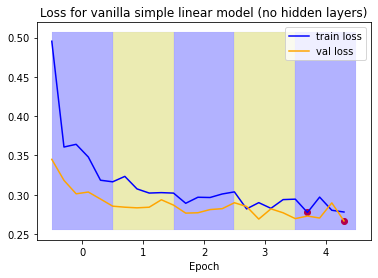

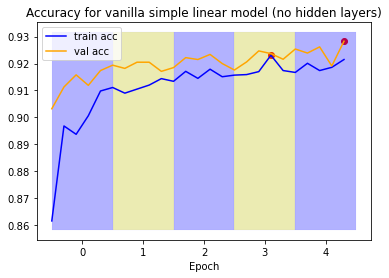

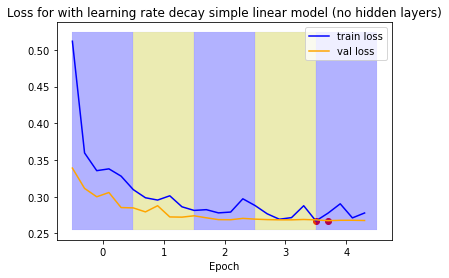

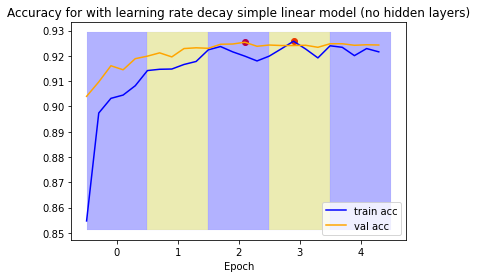

In [105]:
plot_loss_and_accuracy(linear_history_vanilla, linear_network_vanilla)
plot_loss_and_accuracy(linear_history_lr_decay, linear_network_lr_decay)

After you finished the linear network, you can move to a deep network!

In [121]:
class DeepNetwork(Module):
    def __init__(self, dim_input, dim_output, hidden_dim, n_layers, use_tanh=False, name = ""):
        self.W = ModuleList()
        self.b = ModuleList()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.name = name
        self.activation = relu   # relu by default, will change if use_tanh=True
        if use_tanh:
            self.activation = tanh

        # the first hidden layer, takes the input data x as input
        first = LinearNetwork(dim_input, hidden_dim)
        self.W.append(first.W)
        self.b.append(first.b)

        # add all other hidden layers, range(n_layers-1) because we already added a hidden layer
        for i in range(n_layers-1):
            hidden = LinearNetwork(hidden_dim, hidden_dim)
            self.W.append(hidden.W)
            self.b.append(hidden.b)
        
        # the last layer (not hidden, has no activation function), output the logits vector 
        last = LinearNetwork(hidden_dim, dim_output)
        # output_proj, output_bias will not be stored with the other W, b because they require no activation function during the forward pass
        self.output_proj = last.W
        self.output_bias = last.b
        
        # initialize the parameters
        self.init_parameters()
        
    def init_parameters(self):

        for i in range(len(self.W)):
            glorot_init(self.W[i].data)
            zero_init(self.b[i].data)

        # inititlize output_proj & output_bias because they're not stored in self.W, self.b
        glorot_init(self.output_proj.data)
        zero_init(self.output_bias.data)

    def forward(self, x):
        z = x
        # forward trough the hidden layers
        for W, b in zip(self.W, self.b):
            z = self.activation(affine_transform(W, b, z))
            
        # forward trough the last layer (linear, no activation function)
        output = affine_transform(self.output_proj, self.output_bias, z)
        return output
        

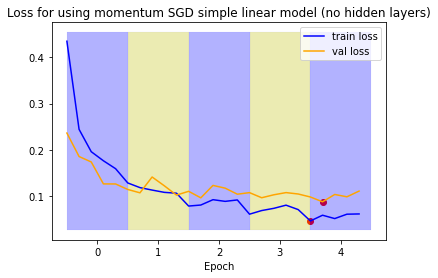

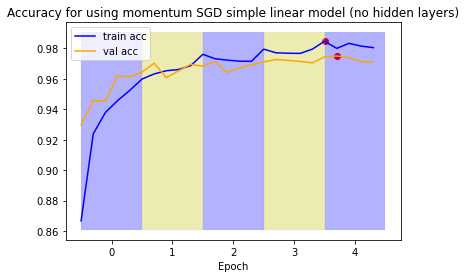

In [124]:
plot_loss_and_accuracy(histories['using momentum SGD'][0],histories['using momentum SGD'][1])

In [280]:
deep_histories_neurons_per_layer = deep_histories

In [ ]:
dim_input = 28*28
dim_output = 10

do_lr_decay = True
do_momentum_SGD = True
for neurons_per_layer in (25,75):
    for do_tanh in (False, True):
        if do_momentum_SGD:
            Opt = MomtenumSGD
        else:
            Opt = SGD
        if do_lr_decay:
            name = "using lr decay"
            if do_momentum_SGD:
                name += " and momentum SGD"
        elif do_momentum_SGD:
            name = "using momentum SGD"
        else:
            name = "vanilla"
        if do_tanh:
            name += "tanh"
        else:
            name += "relu"
        name += "_"+str(neurons_per_layer)
        if name in histories: continue;
        print("training on",name)
        deep_network = DeepNetwork(dim_input, dim_output, neurons_per_layer, 2,name=name, use_tanh=do_tanh)
        deep_optimizer = Opt(deep_network.parameters(), 0.01, lrDecay = do_lr_decay)
        deep_history = training_loop(deep_network, deep_optimizer, train_data, dev_data, n_epochs=5)
        deep_histories_neurons_per_layer[name] = (deep_history, deep_network)
        

training on using lr decay and momentum SGDrelu_25


  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.29655543215269037 and accuracy 0.9085
current test loss 0.31032225410966047 and accuracy 0.9027
current loss 0.2210906330553208 and accuracy 0.937
current test loss 0.22901236928629287 and accuracy 0.9314
current loss 0.2490382625357383 and accuracy 0.9309
current test loss 0.2565044502273002 and accuracy 0.9246
triggering lr decay
current loss 0.17491260584551943 and accuracy 0.9488
current test loss 0.1765489844410479 and accuracy 0.9459
current loss 0.15823963151884868 and accuracy 0.9552
current test loss 0.16655464273623669 and accuracy 0.949
current loss 0.19437060552014832 and accuracy 0.9396
current test loss 0.19256611060982023 and accuracy 0.9372
triggering lr decay
current loss 0.15058108023690822 and accuracy 0.9578
current test loss 0.1509566631965598 and accuracy 0.9543
current loss 0.14604285840403614 and accuracy 0.9581
current test loss 0.14530089762817178 and accuracy 0.9551
current loss 0.13454432984241899 and accuracy 0.962
current test loss 0.1362604

  0%|          | 0/5 [00:00<?, ?it/s]

current loss 0.31240323960206556 and accuracy 0.9045
current test loss 0.34239202236638827 and accuracy 0.8941
current loss 0.22910073996031025 and accuracy 0.9326
current test loss 0.24955336847812024 and accuracy 0.9268
current loss 0.21796502718586083 and accuracy 0.9341
current test loss 0.22964922291802842 and accuracy 0.929
current loss 0.22027154150683081 and accuracy 0.9362
current test loss 0.22404764867076557 and accuracy 0.9306
triggering lr decay
current loss 0.18340727346199825 and accuracy 0.9474


Evaluation on the test set: loss=0.094 accuracy=0.972
Evaluation on the test set: loss=0.111 accuracy=0.968
Evaluation on the test set: loss=0.066 accuracy=0.979
Evaluation on the test set: loss=0.075 accuracy=0.977


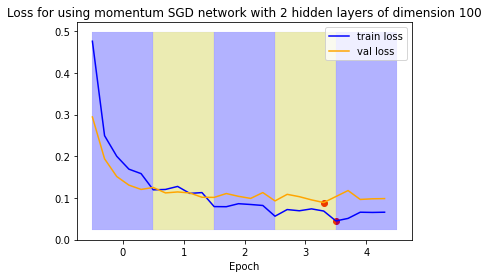

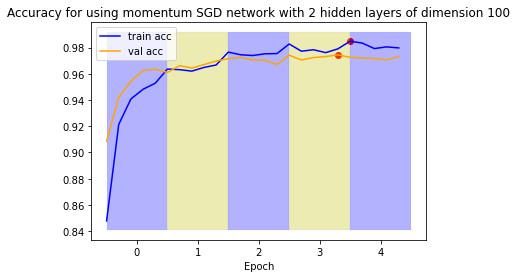

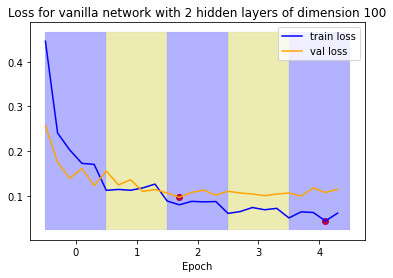

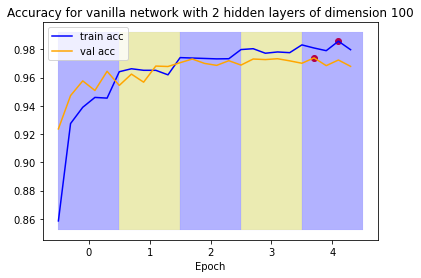

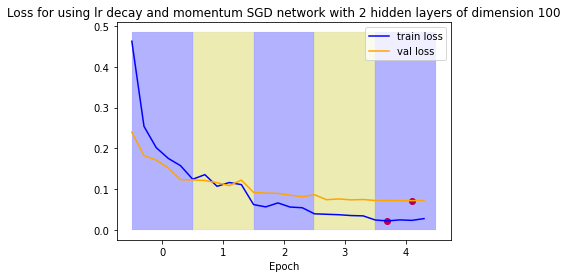

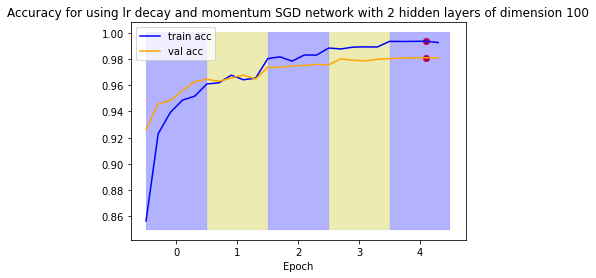

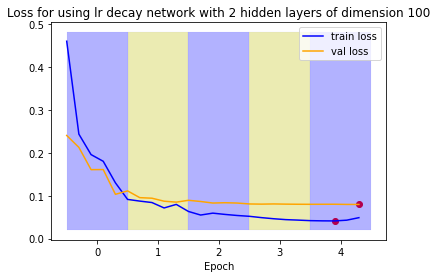

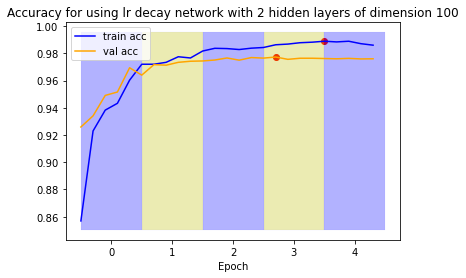

In [167]:
for key in histories.keys():
    (deep_history, deep_network) = histories[key]
    test_loss, test_acc = evaluate(deep_network, test_data)
    print(f'Evaluation on the test set: loss={test_loss:.3f} accuracy={test_acc:.3f}')
    plot_loss_and_accuracy(deep_history, deep_network)

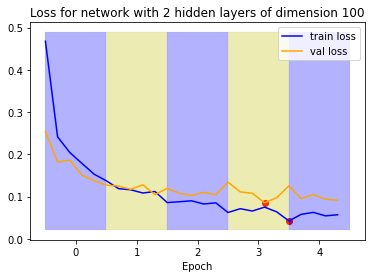

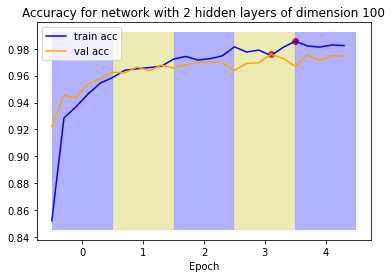

In [79]:
plot_loss_and_accuracy(deep_history, deep_network)

## Bonus

You can try to implement a momentum SGD optimizer! Note that you have to keep track of the velocity for each parameter in the optimizer.
